https://galileo-unbound.blog/2019/07/29/orbiting-photons-around-a-black-hole/

In [ ]:
# for 1000 rays
# 10 s (integration of ray paths) + 200 s (ray rotation) + 300 s (ray tracing to disk) = 8.5 min

In [1]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.spatial.transform import Rotation as R
%matplotlib inline

In [14]:
def create_circle(r): # circle shape for representing BH
    circle = plt.Circle((0,0), radius= r, color = 'black')
    return circle
 
def show_shape(patch): # shows circle shape
    ax=plt.gca()
    ax.add_patch(patch)

def refindex(x,y): # set refraction index thant bends ray
     
    A = 10 # size of BH <----------------- should be global
    eps = 1e-6
     
    rp0 = np.sqrt(x**2 + y**2);
         
    n = 1/(1 - A/(rp0+eps))
    fac = np.abs((1-9*(A/rp0)**2/8))   # approx correction to Eikonal
    nx = -fac*n**2*A*x/(rp0+eps)**3
    ny = -fac*n**2*A*y/(rp0+eps)**3
      
    return [n,nx,ny]
 
def flow_deriv(x_y_z,tspan): # diff equations to solve, yp[2,3] are vx,vy
    x, y, z, w = x_y_z
     
    [n,nx,ny] = refindex(x,y)
         
    yp = np.zeros(shape=(4,))
    yp[0] = z/n
    yp[1] = w/n
    yp[2] = nx
    yp[3] = ny
     
    return yp


def rayplanehits(rays,rotdisk,dave): #checks if ray hits disk
    hit=[]
    for k in range(len(rays)):
        check=False
        for i in range(len(rays[k].T[0])):
            # check distance between each ray point and every disk point
            # this is probably too brute-force and could be done better
            dist=np.sqrt(((rays[k][i]-rotdisk)**2).sum(axis=1))
            filt=dist<dave
            if np.any(filt):
                hit+=[np.linalg.norm(rotdisk[filt][0])]
                check=True
                break
        if check==False: 
            hit+=[-999]
    return hit

def Rx(theta):
    # rotation matrix for ray rotation around yz plane
    theta=theta*np.pi/180
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])

# make uniformly random disk, rotates it
def make_disk(rin,rout,nop,inc):
    stoc=4/np.pi # square to circle
    xs=np.random.random(int(nop*stoc))*2*rout-rout
    ys=np.random.random(int(nop*stoc))*2*rout-rout
    filter=(xs**2+ys**2 <= rout**2)&(xs**2+ys**2 >= rin**2)
    totpt=filter.sum() # actual number of points (due to MC)
    xs=xs[filter]
    ys=ys[filter]
    zs=np.zeros(filter.sum())
    dave=np.sqrt(np.pi*rout**2/nop) # average distance between disk points
    dave 
    # rotates disk
    rd = R.from_euler('y', inc, degrees=True) # rotate wrt y axis
    disk=np.vstack((xs,ys,zs))
    rotdisk=np.array([rd.apply(disk[:,i]) for i in range(len(disk[0]))])
    return rotdisk, dave

4962


Text(0,0.5,'zr')

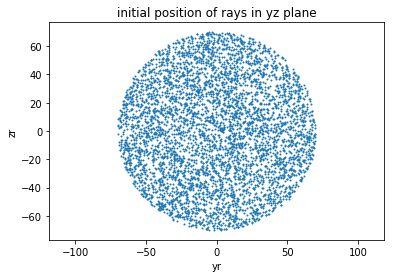

In [11]:
# create initial ray locations
nor=5000 # number of rays
stoc=4/np.pi # square to circle
rmxr=70 # max distance to x
yr=np.random.random(int(nor*stoc))*2*rmxr-rmxr
zr=np.random.random(int(nor*stoc))*2*rmxr-rmxr
filter=(yr**2+zr**2 <= rmxr**2)
print(filter.sum()) # of actual rays (may be different to original due to MC)
yr=yr[filter]
zr=zr[filter]
plt.scatter(yr,zr,s=1)
plt.axis('equal')
plt.title('initial position of rays in yz plane')
plt.xlabel('yr')
plt.ylabel('zr')

In [12]:
# cylindrical coord locations
rray=np.sqrt(yr**2+zr**2)
thray=np.arctan2(zr,yr)*180/np.pi # in deg

In [13]:
%%time 
# integrate rays in 2D (xy plane), 5000 rays take 50 s
# they will be rotated (along yz plane) to their original value later
xstart = -100
nint = 2000
mxxy = 300 # max x or y, avoids extreme numbers produced by odeint
maxt = 400 # this is total ray path integration time, approx. similar to mxxy - fine tune?
A = 10 # size of black hole <---- should connect to
rays=[]
hbh=[] # hits bh?
for ystart in rray: # rays are initially set in 2d (xy plane) and are later rotated
    [n,nx,ny] = refindex(xstart,ystart)
    y0 = [xstart, ystart, n, 0]
    tspan = np.linspace(1,maxt,nint)
    y = integrate.odeint(flow_deriv, y0, tspan)
    xx = y[1:nint,0]
    yy = y[1:nint,1]
    filt2=(np.abs(xx)<mxxy)&(np.abs(yy)<mxxy)
    xx = xx[filt2]
    yy = yy[filt2]
    zz = np.zeros(filt2.sum())
    # cuts off if ray hits the bh
    filt=np.sqrt(xx**2+yy**2)<10
    if np.any(filt):
        cutoff=np.arange(len(filt))[filt][0]
        xx=xx[:cutoff]
        yy=yy[:cutoff]
        zz=zz[:cutoff]
        hbh+=[1]
    else:
        hbh+=[0]
    rays+=[np.vstack((xx,yy,zz))]


/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


CPU times: user 46.2 s, sys: 225 ms, total: 46.4 s
Wall time: 46.6 s


Text(0,0.5,'y')

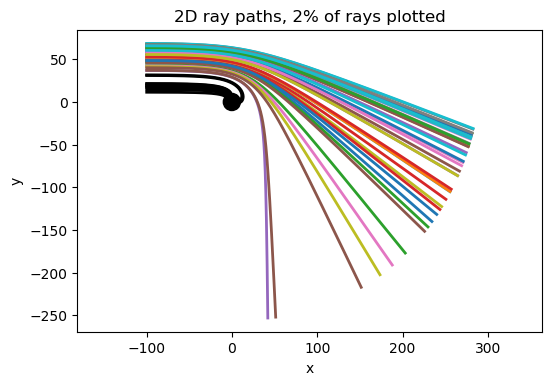

In [15]:
sample = 100 # plot 1 in #sample# rays
plt.figure(dpi=100)
for ray,h in zip(rays[::sample],hbh[::sample]):
    if h == 0:
        lines=plt.plot(ray[0],ray[1])
        plt.setp(lines, linewidth=2)
    else:
        lines=plt.plot(ray[0],ray[1])
        plt.setp(lines, linewidth=2, color = 'black')
plt.axis('equal')
c = create_circle(A)
show_shape(c)
plt.title('2D ray paths, '+str(100*sample//len(rays))+'% of rays plotted')
plt.xlabel('x')
plt.ylabel('y')

Text(0.5,1,'Accretion disk viewed from x')

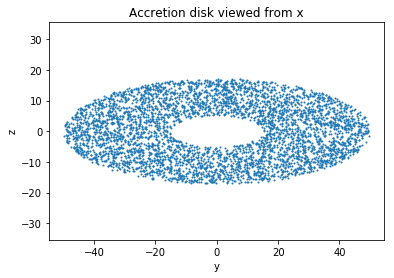

In [248]:
# make an inclined disk
rout = 50 # disk outer r
rin = 15 # disk inner r (close to last photon orbit, fine tune?)
nop = 5e3 # number of init points
inc=20 # inclination
rotdisk,dave = make_disk(rin,rout,nop,inc)
xd=rotdisk[:,0]
yd=rotdisk[:,1]
zd=rotdisk[:,2]
plt.scatter(yd,zd,s=1)
plt.axis('equal')
plt.xlabel('y')
plt.ylabel('z')
plt.title('Accretion disk viewed from x')

In [41]:
%%time
rayrot=[np.array(np.matmul(Rx(ang),ray).T) for ang,ray in zip(thray,rays)]

CPU times: user 366 ms, sys: 97.8 ms, total: 464 ms
Wall time: 521 ms


In [48]:
%%time
# checks if and where (radial distance to bh) a ray hits the disk
hit = rayplanehits(rayrot[:2500],rotdisk,dave) # 1.5 s for 5 rays

CPU times: user 10min 7s, sys: 15.9 s, total: 10min 23s
Wall time: 10min 42s


In [49]:
%%time
# checks if and where (radial distance to bh) a ray hits the disk
hit2 = rayplanehits(rayrot[2500:],rotdisk,dave) # 1.5 s for 5 rays

CPU times: user 10min 6s, sys: 17.2 s, total: 10min 23s
Wall time: 11min 16s


In [50]:
hitt=np.hstack((hit,hit2))

array([-999.        , -999.        ,   27.92847698, ...,   16.85051606,
       -999.        , -999.        ])

In [188]:
# array with initial ray positions in yz plane and radial distance of ray hit to BH
# if ray does not hit the disk, a -999 value appears
proy=np.array([np.append(rayrot[k][0][1:3],h) for k,h in zip(range(len(rayrot)),hitt)])

Text(0.5,1,'All rays (4962) vs. rays that hit the disk (1475)')

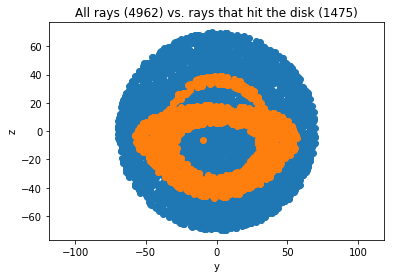

In [251]:
y=proy[:,0]
z=proy[:,1]
plt.scatter(-y,-z)
plt.scatter(-y[proy[:,2]>0],z[proy[:,2]>0])
plt.axis('equal')
plt.xlabel('y')
plt.ylabel('z')
plt.title('All rays ('+str(len(rays))+') vs. rays that hit the disk ('+str((proy[:,2]>0).sum())+')')

/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'Rays that hit the disk, no interpolation')

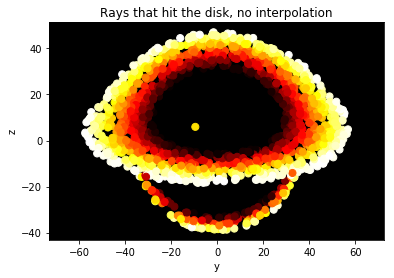

In [372]:
# flipped plot because it looks cooler
y=proy[:,0][proy[:,2]>0]
z=proy[:,1][proy[:,2]>0]
cl=proy[:,2][proy[:,2]>0]
plt.scatter(-y,-z,c=cl,cmap=cm.hot,s=50) # color is set to be more intense farther from the bh
plt.axis('equal')
ax=plt.axes()
ax.set_facecolor('k')
plt.xlabel('y')
plt.ylabel('z')
plt.title('Rays that hit the disk, no interpolation')

In [353]:
c=np.copy(proy[:,2])
#filtbh=(proy[:,2]<0)&(np.array(hbh)==1)
#c[filtbh]=1000
c[c<0]=0

In [369]:
N=500
y=proy[:,0]
z=proy[:,1]

yi = np.linspace(y.min(),y.max(),N)
zi = np.linspace(z.min(),z.max(),N)
Y, Z = np.meshgrid(yi, zi)
P = np.array([Y.flatten(), Z.flatten() ]).transpose()

Vi=(c)
Pi=proy[:,:2]

/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


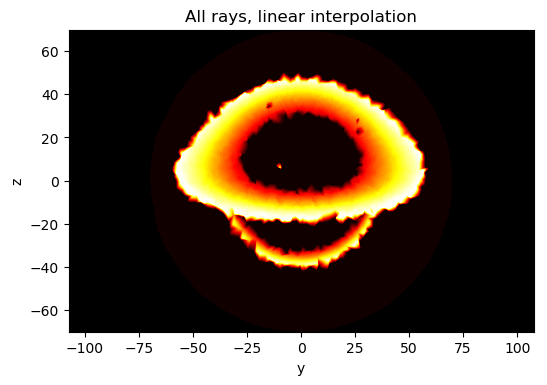

In [370]:
from scipy.interpolate import griddata
V_cubic = griddata(-Pi, Vi, P, method = "linear").reshape([N, N])
plt.figure(dpi=100)
plt.contourf(Y, Z, V_cubic, 50, cmap = cm.hot)
ax=plt.axes()
ax.set_facecolor('k')
plt.axis('equal')
plt.xlim(-100,100)
plt.xlabel('y')
plt.ylabel('z')
plt.title('All rays, linear interpolation')
plt.show()

/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


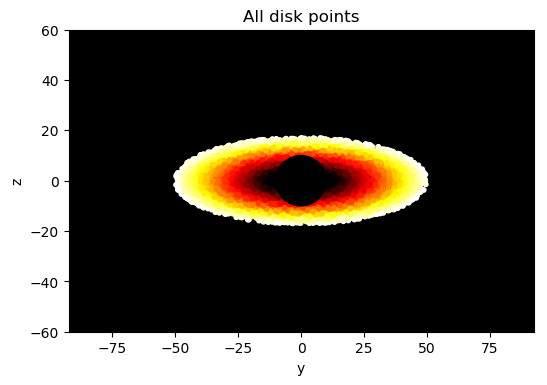

In [368]:
color=np.sqrt(xd**2+yd**2+zd**2)
plt.figure(dpi=100)
plt.scatter(yd,zd,s=10,c=color,cmap = cm.hot)
plt.axis('equal')
plt.xlabel('y')
plt.ylabel('z')
plt.title('All disk points')
ax=plt.axes()
ax.set_facecolor('k')
circ = create_circle(10)
show_shape(circ)
plt.xlim(-100,100)
plt.ylim(-60,60)
plt.show()